# Ejercicios (Grupo 1) - 6 Puntos
1. Implementar Regreción Logística utilizando descenso de gradiente como clasificador con el dataset sintetico generado a continuación.
2. Evaluar la calidad de la predicción utilizando la metrica "Accuracy".
3. Comparar desempeño con y sin termino de regularización en los parametros. Utilizar Cross-Validation para determinar el mejor $\eta$ y $\lambda$ a utilizar.
4. Graficar resultados
5. Utilizar como seed del generador aleatorio el número de legajo de cada uno.
    


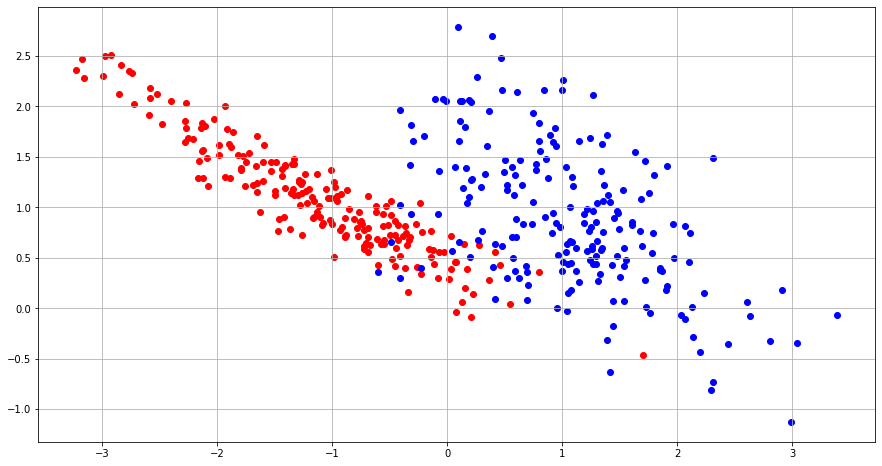

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 15, 8

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# generar dataset de pruebas (Toy Example)
# Fijamos una semilla para obtener siempre el mismo resultado
np.random.seed(13037)

# Generamos un dataset sintetico con la funcion make_classification de sklearn

X, Y = make_classification(n_samples=400, n_classes=2, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

x_pos, x_neg = X[Y == 1], X[Y == 0]    
plt.scatter(x_pos[:, 0], x_pos[:, 1], marker='o', color='r')
plt.scatter(x_neg[:, 0], x_neg[:, 1], marker='o', color='b')    
plt.grid()

##Divicion del dataset en dos partes: training set (80%) y test set (20%)

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

##Funcion Sigmoide

In [3]:
def H(X, W):
    return 1/(1 + np.exp((-X@W.T).astype(np.float64)))

##Funcion de costo

In [4]:
def funcion_loss(X, Y, W, L):
    # X: matriz de muestras de entrenamiento
    # Y: etiquetas
    # W: vector de coeficientes. Incluye el término de "bias" como última componente
    n_samples, n_dim = X.shape
    assert len(Y) == n_samples
    
    w, w0 = W[:n_dim], W[-1]
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    loss = 0
    FR= L *(np.sum(W**2))
    loss = -( Y @ np.log(H(X,W)) + ( 1 - Y ) @ np.log( 1 - H(X,W) ) ) + FR # FR = Factor regularizacion
    return loss

##Funcion de Desenso de gradiente

In [5]:
def gradiente(X, Y, W, L, eta):
    # X: matriz de muestras de entrenamiento
    # Y: etiquetas
    # w: vector de coeficientes. Incluye el término de "bias" como última componente
    n_samples, n_dim = X.shape
    assert len(Y) == n_samples 
    gW = 0
    
    X = np.hstack((X, np.ones((X.shape[0], 1))))

    gW=(H(X,W)-Y)@X-(L-len(Y))*W
       
    return gW

##Entrenador Del Predictor lineal

In [6]:
def train_linear_predictor(X, Y, funcion_loss, gradiente, eta=0.00002,L=0.000001, max_iter=1000, tol=0.001, debug=False):    
    # X: matriz de muestras de entrenamiento
    # Y: etiquetas
    # loss_fn: función de costo. Tiene que tomar como argumentos X, Y y W, con W los parámetros del modelo
    # grad_fn: función que computa (y evalúa en X,Y,W) el gradiente de la 
    #   función de costo respecto de los parámetros del modelo
    # lambda_: parámetro de regularización (weight decay)
    # eta: tasa de aprendizaje
    # max_iter: número máximo de iteraciones de decenso de gradiente
    # tol: criterio de parada por no evolución en la función de costo
    n_samples, n_dim = X.shape
    
    # Initialization "Xavier". Vector de dimensionalidad n_dim +1 porque
    # inicluye el término de bias. Este último se inicializa a cero
    W = np.random.normal(scale=np.sqrt(2./n_dim), size=n_dim+1)
    W[-1] = 0.     
    prev_loss, loss = np.inf, funcion_loss(X, Y, W, L)
    
    # descenso de gradiente
    for t in range(max_iter):
        
        # gradiente en (X,Y,W)
        gW = gradiente(X, Y, W, L, eta)                
        
        W = W - eta*gW
    
        prev_loss = loss
        loss = funcion_loss(X, Y, W, L)
        
        if (prev_loss - loss) / np.abs((prev_loss + 2**-23)) < tol:
            if debug:
                print('done')
            break
        if debug:    
            print('t={}, loss={:.3e}'.format(t, loss))

    return W, loss, t


##Entrenamiento al predictor lineal con factor de refularizacion 

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_train, Y_train)

print(kf)
umbral = 0.5
t=0
Best_eta=0
Best_landa=0
bestScore=0
etas = [0.000001,0.000000001,0.000000000001,0.01,0.0001,0.001,0.00000001]
landas=[0.00001,0.00005,0.0001,0.0005,0.001,0.0025]

for i in range(len(etas)):
  for j in range(len(landas)):
    iter=0
    accuracy=0
    accuracy_sum=0
    for train_index, val_index in kf.split(X):
      print("TRAIN:", train_index)
      print("VALIDATION:", val_index)
      X_train, X_val = X[train_index], X[val_index]
      Y_train, Y_val = Y[train_index], Y[val_index]

      W, loss_train, _ = train_linear_predictor(X_train, Y_train, funcion_loss, gradiente, max_iter=100, eta=etas[i],L=landas[j], tol=1e-9, debug=False)

      Y_val_pred = 1/(1 + np.exp(-W[:-1]@X_val.T+W[-1]))

      
      for x in range(len(Y_val_pred)):
        if Y_val_pred[x] >= umbral:
          Y_val_pred[x]=1
        else:
          Y_val_pred[x]=0
      
      accuracy_sum += accuracy_score(Y_val, Y_val_pred)
    t +=1
    accuracy_prom=accuracy_sum/t
    if accuracy_prom>bestScore:
        bestScore=accuracy_prom
        Best_landa=landas[j]
        Best_eta=etas[i]

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  1   3   4   6   7   8   9  10  12  14  15  16  17  18  19  20  21  22
  23  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  43
  44  45  46  47  48  50  51  53  54  56  58  60  61  62  63  64  65  69
  70  72  73  75  76  77  78  79  82  83  84  85  86  87  89  91  92  94
  95  96  98  99 100 101 102 104 105 106 108 110 113 116 118 119 120 121
 122 123 124 125 126 127 128 129 130 132 133 135 136 137 139 140 141 142
 145 146 147 148 149 150 151 154 155 158 159 160 161 163 164 166 168 169
 171 172 173 174 176 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 197 198 199 200 203 204 206 207 208 210 211 212 213
 214 215 216 217 218 219 222 223 225 226 227 228 229 230 231 232 233 235
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 254 255 257
 261 263 264 265 266 267 268 270 271 273 274 275 276 277 278 279 280 281
 282 283 284 286 288 289 290 291 292 293 294 295 296 297 298 299 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/di

[  3   4  20  35  38  40  41  42  55  57  60  65  71  82  90 105 112 116
 118 123 126 128 135 139 143 148 155 158 167 170 172 173 177 178 181 183
 188 192 197 199 210 211 215 218 226 228 230 236 237 238 246 249 257 264
 270 273 278 282 286 290 294 295 297 300 309 310 317 319 320 336 338 339
 344 347 357 359 369 371 373 395]
TRAIN: [  1   2   3   4   6   7   8   9  10  12  13  14  15  16  17  18  19  20
  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  47  48  49  50  51  52  55  56  57  58  60  61  62
  63  65  66  67  68  70  71  72  73  75  76  77  78  79  80  81  82  84
  85  86  87  88  89  90  92  93  94  95  97 100 101 102 103 105 106 107
 108 109 111 112 113 114 115 116 118 120 121 122 123 124 125 126 127 128
 129 130 132 133 134 135 138 139 140 141 142 143 144 145 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 165 166 167 169 170 172
 173 176 177 178 179 180 181 182 183 184 186 187 188 190 191 192 193 194
 197 198 1

##Resultados del predictor lineal con factor de regularizacion

In [8]:
W, loss_train, t = train_linear_predictor(X_train, Y_train, funcion_loss, gradiente, max_iter=100, eta=Best_eta,L=Best_landa, tol=1e-9, debug=False)
Y_val_pred = 1/(1 + np.exp(-W[:-1]@X_val.T+W[-1]))
for i in range(len(Y_val_pred)):
        if Y_val_pred[i] >= umbral:
          Y_val_pred[i]=1
        else:
          Y_val_pred[i]=0


accuracy = accuracy_score(Y_test, Y_val_pred)
print("eta: ",Best_eta,"landa: ",Best_landa)
print("best score: ", bestScore)
print("accuracy score: ", accuracy)

eta:  1e-06 landa:  1e-05
best score:  2.1875
accuracy score:  0.4875


##Entrenamiento predictor lineal sin factor de regularizacion

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_train, Y_train)

print(kf)
umbral = 0.5
t=0
Best_eta=0
Best_landa=0
bestScore=0
etas = [0.000001,0.000000001,0.000000000001,0.01,0.0001,0.001,0.00000001]
landas=[0]

for i in range(len(etas)):
  for j in range(len(landas)):
    iter=0
    accuracy=0
    accuracy_sum=0
    for train_index, val_index in kf.split(X):
      print("TRAIN:", train_index)
      print("VALIDATION:", val_index)
      X_train, X_val = X[train_index], X[val_index]
      Y_train, Y_val = Y[train_index], Y[val_index]

      W, loss_train, _ = train_linear_predictor(X_train, Y_train, funcion_loss, gradiente, max_iter=100, eta=etas[i],L=landas[j], tol=1e-9, debug=False)

      Y_val_pred = 1/(1 + np.exp(-W[:-1]@X_val.T+W[-1]))

      
      for x in range(len(Y_val_pred)):
        if Y_val_pred[x] >= umbral:
          Y_val_pred[x]=1
        else:
          Y_val_pred[x]=0
      
      accuracy_sum += accuracy_score(Y_val, Y_val_pred)
    t +=1
    accuracy_prom=accuracy_sum/t
    if accuracy_prom>bestScore:
        bestScore=accuracy_prom
        Best_landa=landas[j]
        Best_eta=etas[i]

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  0   1   2   3   5   6   7   8  10  11  12  13  14  15  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  52  53  54  55  56  59  61  62
  63  64  65  66  67  69  70  71  72  74  75  77  79  80  81  82  84  85
  87  88  91  92  94  95  97  98  99 101 102 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 119 120 121 122 123 124 125 126 127 128 129
 130 132 133 134 135 136 139 140 141 142 143 144 145 147 148 150 151 152
 153 156 158 159 160 161 162 163 164 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 184 185 187 188 191 192 193 194 195 196
 197 198 199 200 201 202 204 205 206 207 208 210 211 213 215 217 218 219
 221 222 223 224 225 226 227 228 229 233 234 235 238 240 241 242 243 244
 245 246 247 249 250 251 252 255 257 259 260 262 263 264 265 266 267 268
 269 271 272 273 274 275 276 278 279 280 282 283 284 285 286 287 2

##Resultados del predictor lineal sin factor de regularizacion

In [10]:
W, loss_train, t = train_linear_predictor(X_train, Y_train, funcion_loss, gradiente, max_iter=100, eta=Best_eta,L=Best_landa, tol=1e-9, debug=False)
Y_val_pred = 1/(1 + np.exp(-W[:-1]@X_val.T+W[-1]))
for i in range(len(Y_val_pred)):
        if Y_val_pred[i] >= umbral:
          Y_val_pred[i]=1
        else:
          Y_val_pred[i]=0


accuracy = accuracy_score(Y_test, Y_val_pred)
print("eta: ",Best_eta,"landa: ",Best_landa)
print("best score: ", bestScore)
print("accuracy score: ", accuracy)

eta:  1e-06 landa:  0
best score:  3.3875
accuracy score:  0.4875


# Ejercicios (Grupo 2) - 4 Puntos
1. Implementar Regresión Logística multiclase (One vs All) con dataset Iris utilizando termino de regularización en la funcion de costo. Utilizar Cross-Validation para determinar el mejor $\eta$ y $\lambda$ a utilizar.

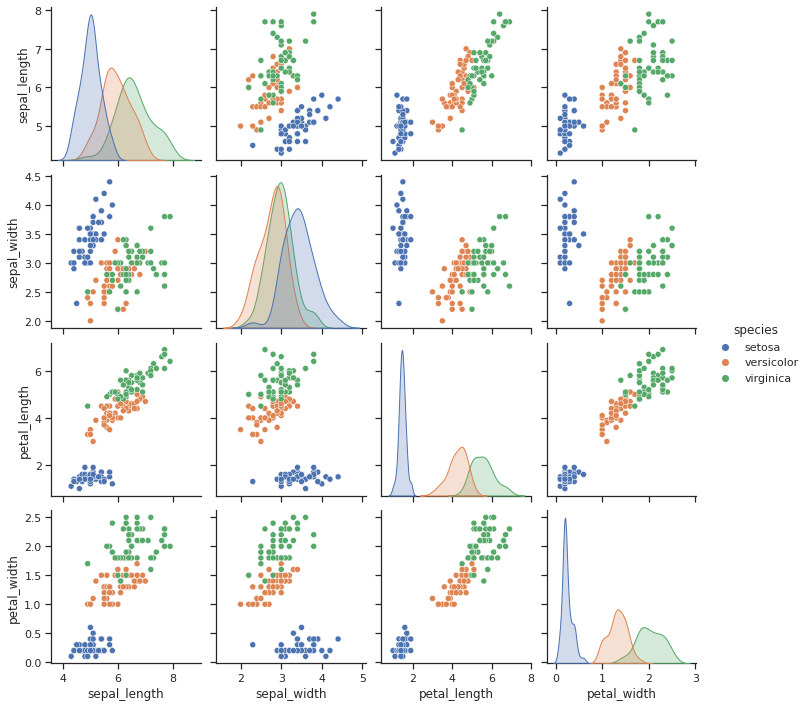

In [11]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

##Separacion de los datos en X y Y

In [12]:
Matriz_Datos = df.values
X = Matriz_Datos[:,0:4]
Y = Matriz_Datos[:, 4]

##Creacion de una matris para las distintas flores

In [13]:
Y_flores=np.zeros((3,len(Y)))
for i in range(len(Y)):
  if Y[i] =='setosa':
    Y_flores[0][i]=1
  elif Y[i]=='versicolor':
    Y_flores[1][i]=1
  elif Y[i]=='virginica':
    Y_flores[2][i]=1
#print(Y_flores)
Y_setosa =Y_flores[0][:]
Y_versicolor = Y_flores[1][:]
Y_virginica = Y_flores[2][:]

##Divicion del dataset en dos partes para cada flor: training set (80%) y test set (20%)

In [14]:
from sklearn.model_selection import train_test_split
X_train_setosa, X_test_setosa, Y_train_setosa, Y_test_setosa = train_test_split(X, Y_setosa, test_size=0.2)
X_train_versicolor, X_test_versicolor, Y_train_versicolor, Y_test_versicolor = train_test_split(X, Y_versicolor, test_size=0.2)
X_train_virginica, X_test_virginica, Y_train_virginica, Y_test_virginica = train_test_split(X, Y_virginica, test_size=0.2)

##Entrenamiento del predictor lineal para la flor setosa (buscando el mejor landa y eta)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_train_setosa, Y_train_setosa)

print(kf)
umbral = 0.5
t=0
Best_eta=0
Best_landa=0
bestScore=0
etas = [0.000001,0.000000001,0.000000000001,0.01,0.0001,0.001,0.00000001]
landas=[0.00001,0.00005,0.0001,0.0005,0.001,0.0025,0.000000001]

for i in range(len(etas)):
  for j in range(len(landas)):
    iter=0
    accuracy=0
    accuracy_sum=0
    for train_index, val_index in kf.split(X):
      print("TRAIN:", train_index)
      print("VALIDATION:", val_index)
      X_train_setosa, X_val_setosa = X[train_index], X[val_index]
      Y_train_setosa, Y_val_setosa = Y_setosa[train_index], Y_setosa[val_index]

      W, loss_train, t = train_linear_predictor(X_train_setosa, Y_train_setosa, funcion_loss, gradiente, tol=1e-20, debug=False)
      
      Y_val_pred_setosa = 1/(1 + np.exp((-W[:-1]@X_val_setosa.T+W[-1]).astype(np.float128)))
      
      for x in range(len(Y_val_pred_setosa)):
        if Y_val_pred_setosa[x] >= umbral:
          Y_val_pred_setosa[x]=1
        else:
          Y_val_pred_setosa[x]=0
      
      accuracy_sum += accuracy_score(Y_val_setosa, Y_val_pred_setosa)
    t +=1
    accuracy_prom=accuracy_sum/t
    if accuracy_prom>bestScore:
        bestScore_setosa=accuracy_prom
        Best_landa_setosa=landas[j]
        Best_eta_setosa=etas[i]

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  1   2   3   4   6   7   9  10  12  13  14  15  16  17  19  21  25  26
  27  28  30  32  33  36  37  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  61  62  63  65  66  67  68  69
  70  71  73  74  75  76  78  79  80  82  83  84  85  86  87  89  90  91
  92  93  94  95  96  98 101 102 104 105 106 107 109 110 111 112 113 115
 116 117 119 120 121 122 123 124 126 127 128 129 130 131 133 134 135 136
 138 139 140 141 142 143 144 145 146 147 148 149]
VALIDATION: [  0   5   8  11  18  20  22  23  24  29  31  34  35  38  60  64  72  77
  81  88  97  99 100 103 108 114 118 125 132 137]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  26  27  28  29  31  32  33  34  35  36  37
  38  39  41  43  44  46  48  50  51  52  53  54  55  56  58  59  60  61
  62  63  64  65  67  68  69  71  72  73  74  75  77  78  79  81  82  83
  84  85  86  88  89

##Entrenamiento y resultados del predictor lineal para la flor setosa (con el mejor eta y landa)

In [16]:
W, loss_train, t = train_linear_predictor(X_train_setosa, Y_train_setosa, funcion_loss, gradiente, eta=Best_eta_setosa,L=Best_landa_setosa, tol=1e-20, debug=False)
Y_val_pred_setosa = 1/(1 + np.exp((-W[:-1]@X_val_setosa.T+W[-1]).astype(np.float128)))
for x in range(len(Y_val_pred_setosa)):
        if Y_val_pred_setosa[x] >= umbral:
          Y_val_pred_setosa[x]=1
        else:
          Y_val_pred_setosa[x]=0


accuracy = accuracy_score(Y_test_setosa, Y_val_pred_setosa)
print("eta: ",Best_eta_setosa,"landa: ",Best_landa_setosa)
print("best score: ", bestScore_setosa)
print("accuracy score: ", accuracy)

eta:  1e-08 landa:  1e-09
best score:  0.027850877192982456
accuracy score:  0.7333333333333333


##Entrenamiento del predictor lineal para la flor versicolor (buscando el mejor landa y eta)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_train_versicolor, Y_train_versicolor)

print(kf)
umbral = 0.5
t=0
Best_eta=0
Best_landa=0
bestScore=0
etas = [0.000001,0.000000001,0.000000000001,0.01,0.0001,0.001,0.00000001]
landas=[0.00001,0.0025,0.000000001,0.00000000001]

for i in range(len(etas)):
  for j in range(len(landas)):
    iter=0
    accuracy=0
    accuracy_sum=0
    for train_index, val_index in kf.split(X):
      print("TRAIN:", train_index)
      print("VALIDATION:", val_index)
      X_train_versicolor, X_val_versicolor = X[train_index], X[val_index]
      Y_train_versicolor, Y_val_versicolor = Y_versicolor[train_index], Y_versicolor[val_index]

      W, loss_train, t = train_linear_predictor(X_train_versicolor, Y_train_versicolor, funcion_loss, gradiente, tol=1e-20, debug=False)
      
      Y_val_pred_versicolor = 1/(1 + np.exp((-W[:-1]@X_val_versicolor.T+W[-1]).astype(np.float128)))
      
      for x in range(len(Y_val_pred_versicolor)):
        if Y_val_pred_versicolor[x] >= umbral:
          Y_val_pred_versicolor[x]=1
        else:
          Y_val_pred_versicolor[x]=0
      
      accuracy_sum += accuracy_score(Y_val_versicolor, Y_val_pred_versicolor)
    t +=1
    accuracy_prom=accuracy_sum/t
    if accuracy_prom>bestScore:
        bestScore_versicolor=accuracy_prom
        Best_landa_versicolor=landas[j]
        Best_eta_versicolor=etas[i]

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  1   2   3   4   5   7   8   9  10  11  12  14  15  16  17  18  21  22
  23  24  25  26  27  28  29  30  32  33  34  35  36  38  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  56  58  59  60  61  62  64
  65  66  67  68  69  70  71  73  74  75  77  79  80  81  82  83  84  85
  86  88  89  90  91  92  93  94  95  96  97  99 103 104 105 106 107 108
 109 110 112 113 114 115 117 118 119 120 121 123 124 125 126 129 131 132
 134 137 138 140 141 142 143 144 146 147 148 149]
VALIDATION: [  0   6  13  19  20  31  37  39  55  57  63  72  76  78  87  98 100 101
 102 111 116 122 127 128 130 133 135 136 139 145]
TRAIN: [  0   1   2   3   4   5   6   9  11  12  13  14  15  16  17  19  20  22
  23  26  28  29  30  31  34  35  36  37  38  39  40  41  42  45  46  47
  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64  65  68  69
  70  71  72  73  75  76  77  78  79  80  81  82  84  87  89  90  91  92
  93  94  95  96  97

##Entrenamiento y resultados del predictor lineal para la flor versicolor (con el mejor eta y landa)

In [18]:
W, loss_train, t = train_linear_predictor(X_train_versicolor, Y_train_versicolor, funcion_loss, gradiente, eta=Best_eta_versicolor,L=Best_landa_versicolor, tol=1e-20, debug=False)
Y_val_pred_versicolor = 1/(1 + np.exp((-W[:-1]@X_val_versicolor.T+W[-1]).astype(np.float128)))
for x in range(len(Y_val_pred_versicolor)):
        if Y_val_pred_versicolor[x] >= umbral:
          Y_val_pred_versicolor[x]=1
        else:
          Y_val_pred_versicolor[x]=0


accuracy = accuracy_score(Y_test_versicolor, Y_val_pred_versicolor)
print("eta: ",Best_eta_versicolor,"landa: ",Best_landa_versicolor)
print("best score: ", bestScore_versicolor)
print("accuracy score: ", accuracy)

eta:  1e-08 landa:  1e-11
best score:  0.043055555555555555
accuracy score:  0.1


##Entrenamiento del predictor lineal para la flor virginica (buscando el mejor landa y eta)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_train_virginica, Y_train_virginica)

print(kf)
umbral = 0.5
t=0
Best_eta=0
Best_landa=0
bestScore=0
etas = [0.000001,0.000000001,0.000000000001,0.01,0.0001,0.001,0.00000001]
landas=[0.00001,0.00005,0.0001,0.0025,0.000000001,0.00000000001]

for i in range(len(etas)):
  for j in range(len(landas)):
    iter=0
    accuracy=0
    accuracy_sum=0
    for train_index, val_index in kf.split(X):
      print("TRAIN:", train_index)
      print("VALIDATION:", val_index)
      X_train_virginica, X_val_virginica = X[train_index], X[val_index]
      Y_train_virginica, Y_val_virginica = Y_virginica[train_index], Y_virginica[val_index]

      W, loss_train, t = train_linear_predictor(X_train_virginica, Y_train_virginica, funcion_loss, gradiente, tol=1e-20, debug=False)
      
      Y_val_pred_virginica = 1/(1 + np.exp((-W[:-1]@X_val_virginica.T+W[-1]).astype(np.float128)))
      
      for x in range(len(Y_val_pred_virginica)):
        if Y_val_pred_virginica[x] >= umbral:
          Y_val_pred_virginica[x]=1
        else:
          Y_val_pred_virginica[x]=0
      
      accuracy_sum += accuracy_score(Y_val_virginica, Y_val_pred_virginica)
    t +=1
    accuracy_prom=accuracy_sum/t
    if accuracy_prom>bestScore:
        bestScore_virginica=accuracy_prom
        Best_landa_virginica=landas[j]
        Best_eta_virginica=etas[i]

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  29  30  32  33  34  36  37  38  39  41  43
  44  45  46  47  48  49  50  52  53  55  56  57  58  59  61  62  63  64
  66  67  68  69  70  71  72  73  74  75  76  77  78  81  82  85  86  87
  89  91  92  94  96  97  98 100 101 103 104 105 107 110 111 112 113 114
 115 116 117 118 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 136 137 138 139 140 141 142 144 145 146 149]
VALIDATION: [  3  23  27  28  31  35  40  42  51  54  60  65  79  80  83  84  88  90
  93  95  99 102 106 108 109 119 135 143 147 148]
TRAIN: [  0   2   3   4   5   7   9  10  12  13  14  15  17  19  20  23  24  26
  27  28  29  30  31  33  34  35  37  39  40  41  42  43  44  46  47  48
  49  50  51  52  54  55  56  57  58  59  60  61  62  64  65  67  68  69
  70  71  72  74  76  78  79  80  82  83  84  85  86  87  88  89  90  92
  93  94  95  98  99

##Entrenamiento y resultados del predictor lineal para la flor virginica (con el mejor eta y landa)

In [20]:
W, loss_train, t = train_linear_predictor(X_train_virginica, Y_train_virginica, funcion_loss, gradiente, eta=Best_eta_virginica,L=Best_landa_virginica, tol=1e-20, debug=False)
Y_val_pred_virginica = 1/(1 + np.exp((-W[:-1]@X_val_virginica.T+W[-1]).astype(np.float128)))
for x in range(len(Y_val_pred_virginica)):
        if Y_val_pred_virginica[x] >= umbral:
          Y_val_pred_virginica[x]=1
        else:
          Y_val_pred_virginica[x]=0


accuracy = accuracy_score(Y_test_virginica, Y_val_pred_virginica)
print("eta: ",Best_eta_virginica,"landa: ",Best_landa_virginica)
print("best score: ", bestScore_virginica)
print("accuracy score: ", accuracy)

eta:  1e-08 landa:  1e-11
best score:  0.004433333333333333
accuracy score:  0.5333333333333333
